This notebook prepares figures for the BCN20000 dataset:
- Diagnosis distribution (multi-class)
- Benign vs malignant mapping
- Age distribution (binned)
- Sex distribution
- Localization distribution
Outputs are saved to ../artifacts/plots/ and displayed inline.

In [36]:
import sys, os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data_loader import _dataset_roots

Load CSVs and return combined DataFrame for a given split. Uses the KaggleHub cache paths discovered by the project’s loader.

In [37]:
def get_csv_paths(base_dir=None):
    root, train_imgs, test_imgs, train_csv, test_csv = _dataset_roots(base_dir)
    return {"root": root, "train_csv": train_csv, "test_csv": test_csv}

def load_split_df(split="train", base_dir=None):
    paths = get_csv_paths(base_dir)
    if split == "train":
        return pd.read_csv(paths["train_csv"])
    if split == "test":
        return pd.read_csv(paths["test_csv"])
    return pd.concat([pd.read_csv(paths["train_csv"]), pd.read_csv(paths["test_csv"])], ignore_index=True)

Derive helper columns used in slides: malignant/benign, age bins, and cleaned categorical fields.

In [38]:
def map_malignancy(df):
    malignant = {"MEL","SCC","BCC"}
    df = df.copy()
    df["diagnosis"] = df["diagnosis"].astype(str).str.upper()
    df["malignancy"] = np.where(df["diagnosis"].isin(malignant), "malignant", "benign")
    return df

def add_age_bins(df):
    df = df.copy()
    bins = [0,20,40,60,80,100]
    labels = ["(0,20]","(20,40]","(40,60]","(60,80]","(80,100]"]
    df["age_bin"] = pd.cut(df["age_approx"].astype(float), bins=bins, labels=labels, include_lowest=True)
    return df

def clean_categories(df):
    df = df.copy()
    if "sex" in df.columns:
        df["sex"] = df["sex"].fillna("unknown").str.lower()
    if "anatom_site_general" in df.columns:
        df["anatom_site_general"] = df["anatom_site_general"].fillna("unknown").str.lower()
    return df

Generic plotting helpers to make clean pie and bar charts and save them.

In [39]:
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)
    return path

def plot_pie(series, title, save_path=None):
    counts = series.value_counts(dropna=False)
    total = int(counts.sum())
    labels = [f"{str(k)} ({int(v)}, {100.0*float(v)/total:.1f}%)" for k, v in counts.items()]
    fig, ax = plt.subplots(figsize=(7,7))
    wedges, texts = ax.pie(counts.values, startangle=90)
    ax.legend(wedges, labels, title="Categories", loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title(f"{title} (N={total})")
    if save_path:
        ensure_dir(os.path.dirname(save_path))
        fig.savefig(save_path, bbox_inches="tight")
    plt.show()
    plt.close(fig)

def plot_bar(series, title, top_n=None, rotate=45, save_path=None, color_map=None):
    counts = series.value_counts(dropna=False)
    if top_n is not None:
        counts = counts.head(top_n)
    total = int(counts.sum())

    xs = counts.index.astype(str).tolist()
    ys = counts.values.astype(int)

    colors = None
    if color_map is not None:
        colors = [color_map.get(cat, "gray") for cat in xs]

    fig, ax = plt.subplots(figsize=(10,5))
    bars = ax.bar(xs, ys, color=colors)
    for i, v in enumerate(ys):
        pct = 100.0*float(v)/total if total > 0 else 0.0
        ax.text(i, v, f"{v} ({pct:.1f}%)", ha="center", va="bottom", fontsize=9)
    ax.set_title(f"{title} (N={total})")
    ax.set_ylabel("Count")
    ax.set_xticks(range(len(xs)))
    ax.set_xticklabels(xs, rotation=rotate, ha="right")

    if color_map:
        legend_handles = []
        for label, color in dict(malignant="red", benign="green").items():
            legend_handles.append(plt.Rectangle((0,0),1,1, color=color))
        ax.legend(legend_handles, ["Malignant", "Benign"],
                  title="Category", loc="center left", bbox_to_anchor=(1, 0.5))

    if save_path:
        ensure_dir(os.path.dirname(save_path))
        fig.savefig(save_path, bbox_inches="tight")
    plt.show()
    plt.close(fig)

Distribution exporter.

In [40]:
def export_distribution(series, out_csv_path, column_name):
    counts = series.value_counts(dropna=False)
    total = int(counts.sum())
    df = pd.DataFrame({
        column_name: counts.index.astype(str),
        "count": counts.values.astype(int),
        "percent": [100.0*float(v)/total if total>0 else 0.0 for v in counts.values]
    })
    ensure_dir(os.path.dirname(out_csv_path))
    df.to_csv(out_csv_path, index=False)
    return out_csv_path

Generate all figures for a chosen split and write a compact JSON summary.

In [41]:
def generate_slide_figures(split="train", out_dir="../artifacts/plots", tag="bcn20k"):
    df = load_split_df(split=split)
    df = map_malignancy(df)
    df = add_age_bins(df)
    df = clean_categories(df)

    # Diagnosis -> bar chart with benign/malignant colors
    malignant = {"MEL","SCC","BCC"}
    diag_color_map = {
        dx: ("red" if dx in malignant else "green")
        for dx in df["diagnosis"].unique()
    }
    plot_bar(df["diagnosis"], f"Diagnosis distribution ({split})",
             rotate=45,
             save_path=os.path.join(out_dir, f"{tag}_{split}_diagnosis_bar.png"),
             color_map=diag_color_map)
    export_distribution(df["diagnosis"],
                        f"../artifacts/{tag}_{split}_diagnosis_distribution.csv",
                        "diagnosis")

    # Malignancy -> pie chart
    plot_pie(df["malignancy"], f"Benign vs malignant ({split})",
             os.path.join(out_dir, f"{tag}_{split}_malignancy_pie.png"))
    export_distribution(df["malignancy"],
                        f"../artifacts/{tag}_{split}_malignancy_distribution.csv",
                        "malignancy")

    # Age bins -> pie chart
    plot_pie(df["age_bin"], f"Age distribution ({split})",
             os.path.join(out_dir, f"{tag}_{split}_age_pie.png"))
    export_distribution(df["age_bin"],
                        f"../artifacts/{tag}_{split}_age_distribution.csv",
                        "age_bin")

    # Sex -> pie chart
    plot_pie(df["sex"], f"Sex distribution ({split})",
             os.path.join(out_dir, f"{tag}_{split}_sex_pie.png"))
    export_distribution(df["sex"],
                        f"../artifacts/{tag}_{split}_sex_distribution.csv",
                        "sex")

    # Localization -> bar chart
    if "anatom_site_general" in df.columns:
        plot_bar(df["anatom_site_general"], f"Localization distribution ({split})",
                 rotate=60,
                 save_path=os.path.join(out_dir, f"{tag}_{split}_localization_bar.png"))
        export_distribution(df["anatom_site_general"],
                            f"../artifacts/{tag}_{split}_localization_distribution.csv",
                            "anatom_site_general")

    summary = {
        "split": split,
        "total_rows": int(len(df)),
        "n_diagnosis": int(df["diagnosis"].nunique()),
        "malignant_ratio": float((df["malignancy"]=="malignant").mean()),
        "sex_counts": df["sex"].value_counts(dropna=False).to_dict(),
        "age_bin_counts": df["age_bin"].value_counts(dropna=False).astype(int).to_dict(),
    }
    ensure_dir("../artifacts")
    pd.DataFrame([summary]).to_json(f"../artifacts/{tag}_{split}_summary.json",
                                    orient="records", indent=2)
    return summary


Run for all splits.

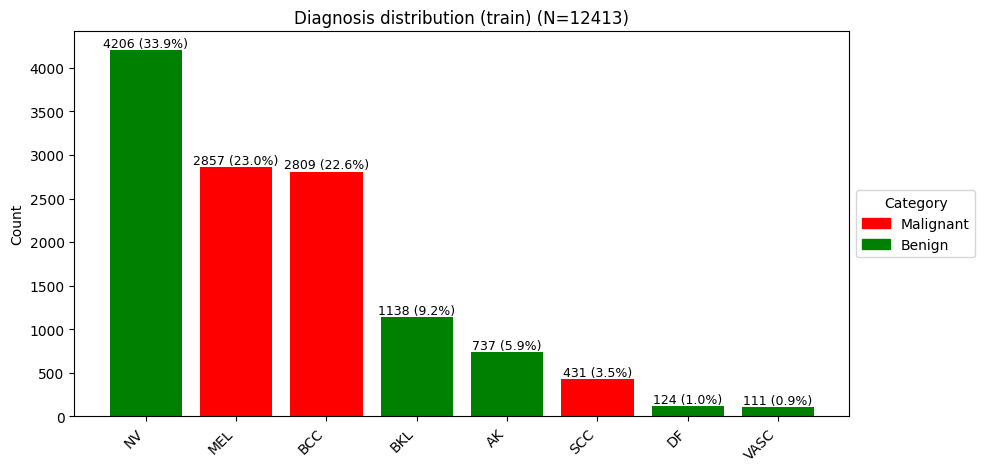

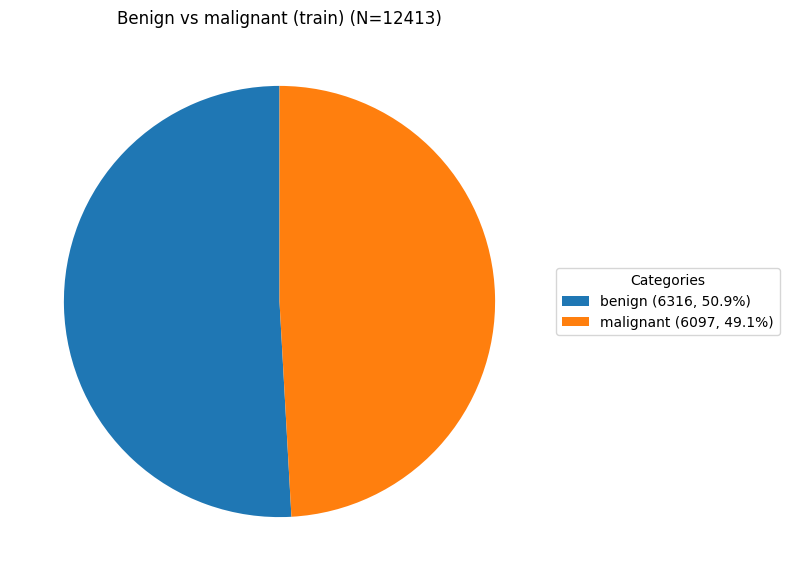

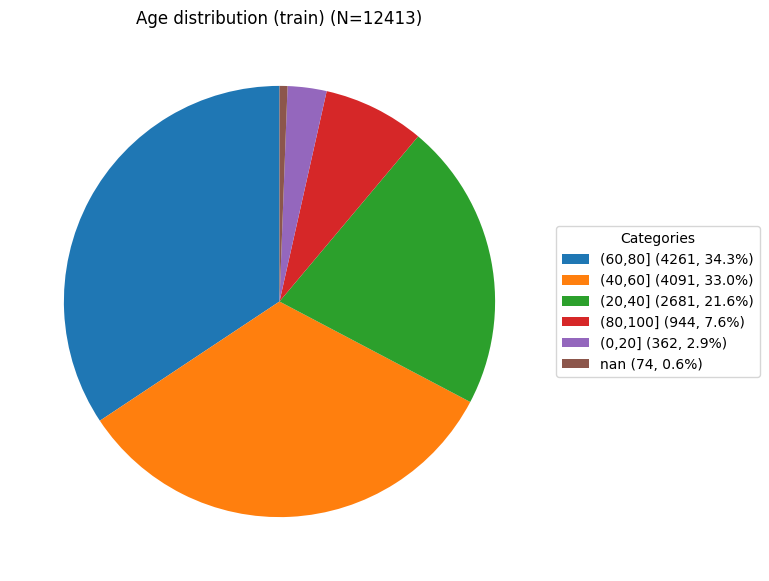

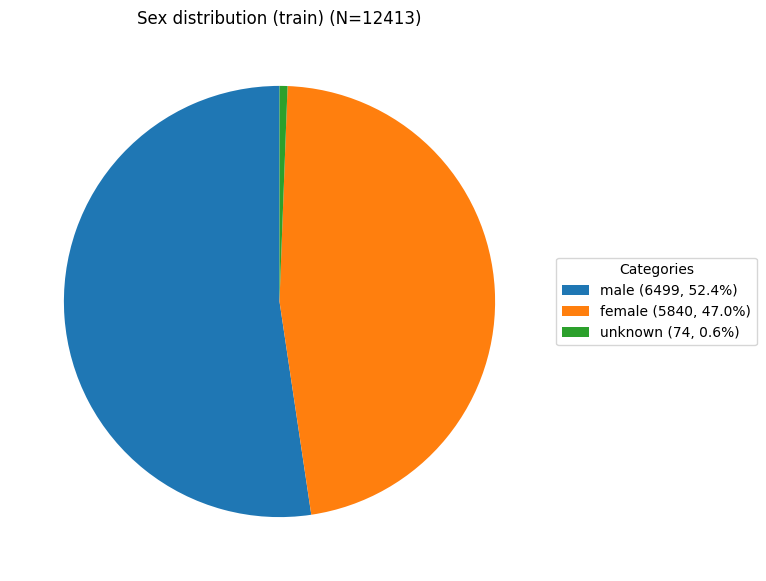

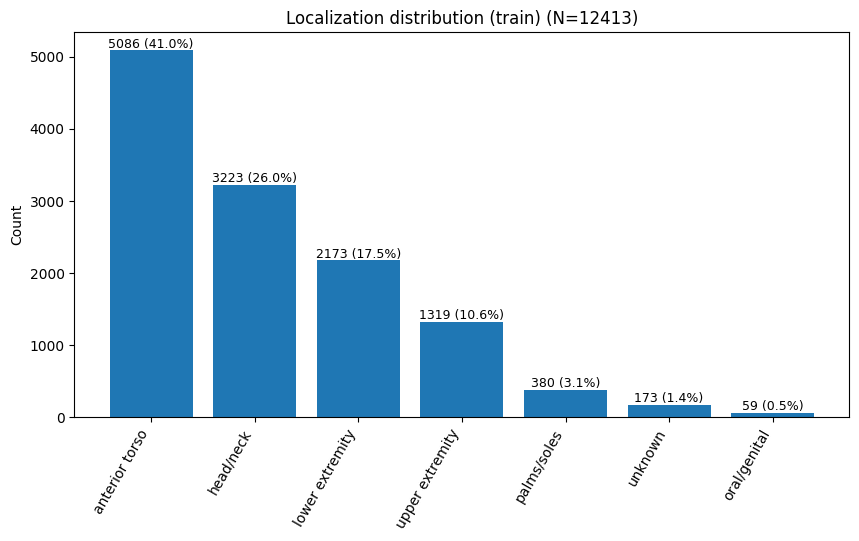

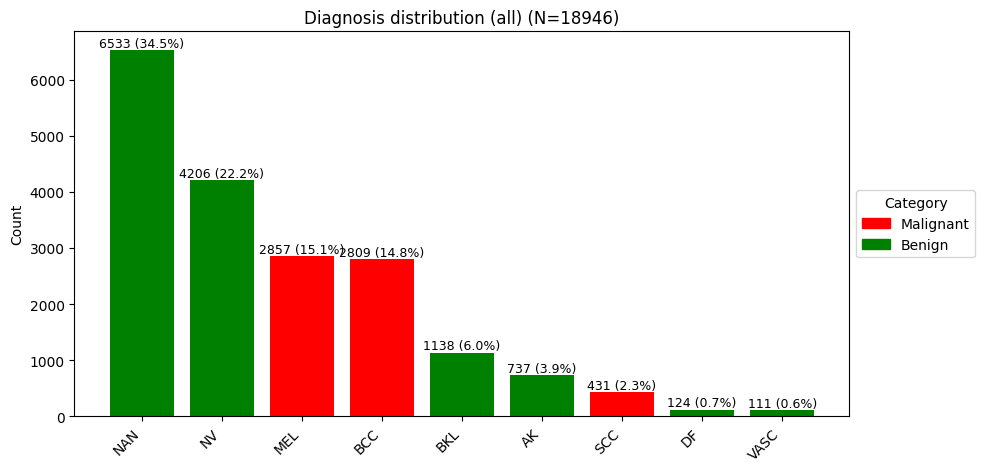

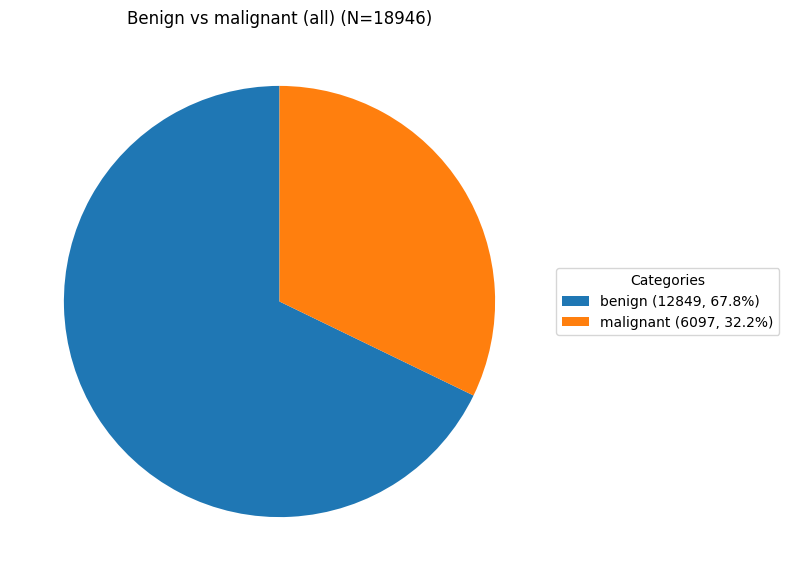

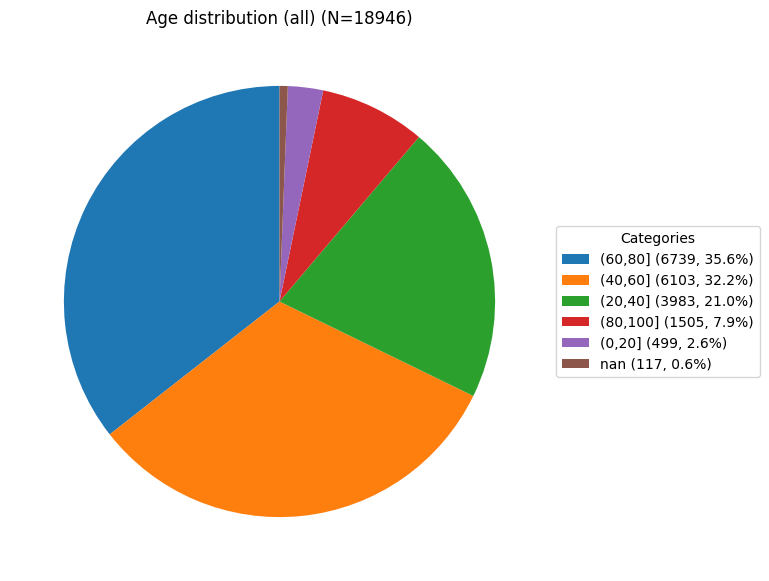

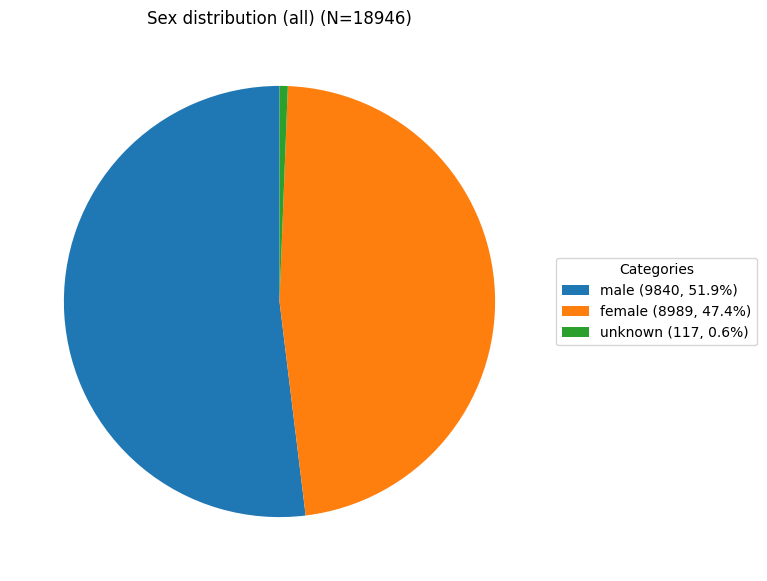

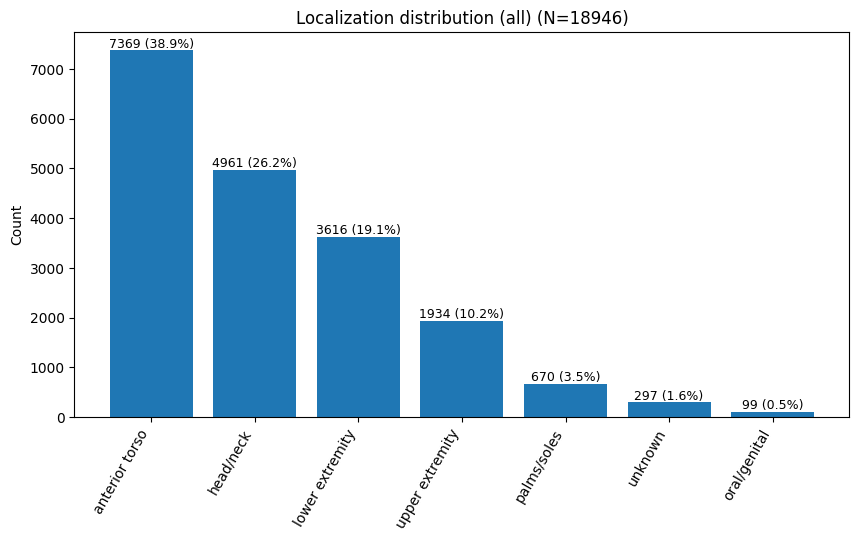

{'train': {'split': 'train',
  'total_rows': 12413,
  'n_diagnosis': 8,
  'malignant_ratio': 0.49117860307741884,
  'sex_counts': {'male': 6499, 'female': 5840, 'unknown': 74},
  'age_bin_counts': {'(60,80]': 4261,
   '(40,60]': 4091,
   '(20,40]': 2681,
   '(80,100]': 944,
   '(0,20]': 362,
   nan: 74}},
 'all': {'split': 'all',
  'total_rows': 18946,
  'n_diagnosis': 9,
  'malignant_ratio': 0.3218093528977093,
  'sex_counts': {'male': 9840, 'female': 8989, 'unknown': 117},
  'age_bin_counts': {'(60,80]': 6739,
   '(40,60]': 6103,
   '(20,40]': 3983,
   '(80,100]': 1505,
   '(0,20]': 499,
   nan: 117}}}

In [42]:
def generate_all_summaries(out_dir="../artifacts/plots", tag="bcn20k"):
    train_summary = generate_slide_figures(split="train", out_dir=out_dir, tag=tag)
    all_summary = generate_slide_figures(split="all", out_dir=out_dir, tag=tag)
    return {"train": train_summary, "all": all_summary}

summaries = generate_all_summaries()
summaries